In [5]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import numpy as np
!pip install tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score

In [6]:
#os.chdir("/Users/michelkauffmann/Downloads")
u = loadmat('u_F_xyz_T1.mat')["u_F"]
v = loadmat('v_F_xyz_T1.mat')["v_F"]
w = loadmat('w_F_xyz_T1.mat')["w_F"]
tau_11 = loadmat('tau11_xyz_T1.mat')["tau11"]

In [7]:
u.shape == v.shape == w.shape == tau_11.shape

True

In [8]:
tau_11.shape

(146, 96, 75)

In [9]:
x = np.array([u, v, w])
x = np.transpose(x, [1, 2, 3, 0])

In [10]:
x.shape

(146, 96, 75, 3)

In [11]:
x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [12]:
sample = []
size = 3
y = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            #print(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :].shape)
            y.append(tau_11[i - size][j - size][k - size])

In [13]:
x = np.stack(sample, axis = 0)
x.shape

(1051200, 7, 7, 7, 3)

In [14]:
y = np.array(y)
y.shape

(1051200,)

In [15]:
mask =  np.random.rand(x.shape[0]) < 0.80
x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]
y_train, y_test = y[mask], y[~mask]
#x_train.shape
#x_train, x_test = x[:800000, :, :, :, :], x[800000:, :, :, :, :]
#y_train, y_test = y[:800000], y[800000:]

In [21]:
model = keras.Sequential([
    tf.keras.layers.Conv3D(32,
                     kernel_size = (3,3,3),
                     activation = "relu",
                     input_shape = (7,7,7,3),   
                     padding = "same"),
                     #kernel_regularizer = regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling3D(pool_size = (2,2,2)),
    tf.keras.layers.Conv3D(64, 
                     kernel_size = (3,3,3), 
                     activation = "relu",
                     padding = "same"),
                     #kernel_regularizer = regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling3D(pool_size = (2,2,2)),
    tf.keras.layers.Conv3D(64, 
                     kernel_size = (3,3,3), 
                     activation = "relu",
                     padding = "same"),
                     #kernel_regularizer = regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling3D(pool_size = (1,1,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),# kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss = 'mse',
                optimizer = tf.train.AdamOptimizer())
                #metrics = ['mse'])

In [23]:
#model = model
#model.summary()

In [24]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
#                                               min_delta = 0.0001,
#                                               patience = 5,
#                                               verbose = 1)

In [25]:
history = model.fit(x_train, y_train, 
                    epochs = 50,
                    validation_split = 0.2, 
                    batch_size = 10000)
                    #callbacks = [early_stopping])

Train on 673039 samples, validate on 168260 samples
Epoch 1/50
673039/673039 [==============================] - 34s 51us/step - loss: 3.5850e-04 - val_loss: 3.4667e-04
Epoch 2/50
673039/673039 [==============================] - 29s 43us/step - loss: 2.2795e-04 - val_loss: 4.1592e-04
Epoch 3/50
673039/673039 [==============================] - 29s 43us/step - loss: 2.0052e-04 - val_loss: 4.4138e-04
Epoch 4/50
673039/673039 [==============================] - 29s 43us/step - loss: 1.7325e-04 - val_loss: 4.1287e-04
Epoch 5/50
673039/673039 [==============================] - 29s 43us/step - loss: 1.5898e-04 - val_loss: 5.8469e-04
Epoch 6/50
673039/673039 [==============================] - 29s 43us/step - loss: 1.6841e-04 - val_loss: 3.5082e-04
Epoch 7/50
673039/673039 [==============================] - 29s 43us/step - loss: 1.4020e-04 - val_loss: 3.6045e-04
Epoch 8/50
673039/673039 [==============================] - 29s 43us/step - loss: 1.3791e-04 - val_loss: 3.3264e-04
Epoch 9/50
673039/67

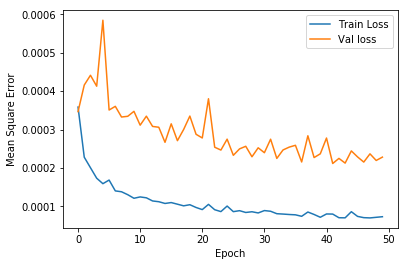

In [26]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
plt.legend()

In [27]:
y_pred = model.predict(x_test).flatten()
y_true = y_test

In [28]:
print("R^2: %.4f\n" % r2_score(y_true, y_pred))

R^2: 0.8332



In [29]:
np.corrcoef(y_pred, y_true)[0, 1]

0.9164940076610179